# Visualize conv layers after training

See excellent [blog post on this subject](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030), and [nice Deep Dream implementation with fastai](https://github.com/kheyer/ML-DL-Projects/blob/master/Pytorch%20Deep%20Dream/dreaming.ipynb).

In [1]:
%matplotlib inline

from fastai import *
from fastai.vision import *

from IPython.display import display
PATH = os.path.abspath('../..')

# Load trained model

In [2]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)


In [3]:
bs = 128
sz = 128

seed = 1234

tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_zoom=1.15, p_lighting=0)

data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )

In [123]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, ps=[0.25, 0.5], loss_func=root_mean_squared_error)
learn.load('resnet34-experiment_B5');

m = learn.model.eval()

# Test


In [111]:
def get_random_image(sz=56, seed=1234):    
    return torch.FloatTensor(sz, sz, 3).uniform_(0.5, 0.8)

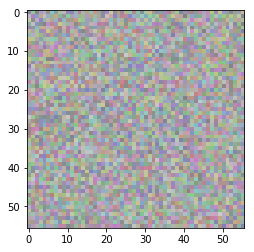

In [112]:
img = get_random_image()
plt.imshow(img)

In [122]:
m(img[None])

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 56, 56, 3] to have 3 channels, but got 56 channels instead

# Update random noise based on activations

This is essentially the same thing as the first step in the DeepDream [implementation](https://github.com/kheyer/ML-DL-Projects/blob/master/Pytorch%20Deep%20Dream/dreaming.ipynb) from **kheyer** 

In [36]:
def get_random_image(sz=56, seed=1234):    
    return np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255

In [28]:
def update_image(image, model, iterations, lr, loss_fn, tfms, opt=None):

    image = image.clone().detach().requires_grad_(True)
    
    if opt == 'SGD':
        opt = optim.SGD([image], lr)
    elif opt == 'Adam':
        opt = optim.Adam([image], lr, weight_decay=1e-6)
        
    for i in range(iterations):
        if opt is not None:
            opt.zero_grad()
        else:
            model.zero_grad()
        out = model(image)
        loss = loss_fn(out)
        loss.backward()
        
        if opt is not None:
            opt.step()
        else:
            image.data = image.data + lr*image.grad.data
            
    image = tfms.denorm(image.data.cpu().numpy()[0].transpose(1,2,0))
    
    im = PIL.Image.fromarray(np.uint8(image*255))
    
    return im


In [37]:
# the "pipeline"
def optimize_activation(model, iterations, lr, loss_fn, tfms, opt=None):
    image = get_random_image()
    image = torch.from_numpy(image).cuda()
    image = tfms(image)
    
    return update_image(image, model, iterations, lr, loss_fn, tfms, opt=opt)

In [38]:
# different loss functions for activations
class activation_losses():
    def __init__(self, idxs):
        self.idxs = idxs
        
    def layer_loss(self, pred):
        return -pred.mean()

    def channel_loss(self, pred):
        a, b = self.idxs
        return -pred[a, b].mean()

    def neuron_loss(self, pred):
        a, b, c, d = self.idxs
        return -pred[a,b,c,d]

    def logit_loss(self, pred):
        a = self.idxs
        return -pred[:,a]
    
    def norm_loss(self, pred):
        return pred.norm()



In [40]:
# layer loss
im = optimize_activation(model, 300, 0.3, activation_losses([]).layer_loss, tfms[0], opt='Adam')
im

TypeError: 'list' object is not callable

# Adapt code made by Fabio M. Graetz
**NOTE: this needs to updated to Fastai v1**

In [43]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [48]:
class FilterVisualizer():
    def __init__(self, model=model, tfms=tfms, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = model.cuda().eval()
        self.tfms = tfms

    def visualize(self, layer, filter_num, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter_num].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter_num)
        activations.close()
        
    def save(self, layer, filter_num):
        plt.imsave(f'layer_{layer}_filter_{filter_num}.jpg', np.clip(self.output, 0, 1))

# Test run

In [49]:
layer = 40
filter_num = 265
FV = FilterVisualizer(model=model.eval(), tfms=tfms, size=56, upscaling_steps=12, upscaling_factor=1.2)
FV.visualize(layer, filter_num, blur=5)

IndexError: list index out of range